In [111]:
import numpy as np
from math import factorial
from scipy.stats import chi2, chisquare
import scipy as scipy
import matplotlib.pyplot as plt  
from collections import Counter


In [105]:
def truncated_poisson_pmf(lam, m):
    """
    Return the normalised pmf P(i) ∝ λ^i / i!   for i = 0,…,m.
    """
    unnorm = np.array([lam**i / factorial(i) for i in range(m+1)], dtype=float)
    return unnorm / unnorm.sum()

def mh_trunc_poisson(lam, m, n_draw, burn_in=1000, seed=None):
    """
    Draw `n_draw` samples from the Poisson(λ) truncated at {0,…,m}
    using a simple ±1 Metropolis–Hastings chain.
    """
    rng = np.random.default_rng(seed)
    P   = truncated_poisson_pmf(lam, m)
    
    chain = np.empty(n_draw + burn_in, dtype=int)
    state = rng.integers(0, m+1)          # random start
    
    for t in range(n_draw + burn_in):
        # propose j = state ± 1, reflecting at the boundaries
        prop = state + rng.choice((-1, 1))
        if prop < 0 or prop > m:
            prop = state
        
        # MH acceptance
        if rng.random() < min(1.0, P[prop]/P[state]):
            state = prop
        
        chain[t] = state
    
    return chain[burn_in:], n_draw                # drop burn-in

def chi2_gof(counts, probs):
    """Return χ² statistic, p-value, and degrees-of-freedom."""
    n      = counts.sum()
    expect = n * probs
    stat   = ((counts - expect)**2 / expect).sum()
    dof    = len(counts) - 1              # no fitted params
    stat, p_val = chisquare(f_obs=counts, f_exp=expect)
    return stat, p_val, dof

In [108]:
lam    = 8   # traffic intensity (same A as in Exercise 4)
m      = 10        # trunk capacity
Nkeep  = 50_000    # draws after burn-in
BURN   = 4_000
SEED   = 123

pmf    = truncated_poisson_pmf(lam, m)
sample, n_draw = mh_trunc_poisson(lam, m, Nkeep, burn_in=BURN, seed=SEED)
counts = np.bincount(sample, minlength=m+1)
P   = truncated_poisson_pmf(lam, m)
chi2_stat, chi2_p, dof = chi2_gof(counts, pmf)

print(f"λ = {lam},  m = {m}")
print(f"Sample size (post burn-in): {Nkeep:,}")
print(f"χ² statistic = {chi2_stat:.2f}  (d.o.f. = {dof})")
print(f"p-value      = {chi2_p:.4f}")
if chi2_p < 0.05:
    print("→ Reject truncated-Poisson at 5 % level")
else:
    print("→ Fail to reject (good fit)")
total_moves   = n_draw + BURN  
accepted = np.sum(sample[1:] != sample[:-1])     # a state change ⇒ accept
acc_rate      = accepted / total_moves
print(f"Acceptance rate = {acc_rate:.3%}")

λ = 8,  m = 10
Sample size (post burn-in): 50,000
χ² statistic = 12.22  (d.o.f. = 10)
p-value      = 0.2706
→ Fail to reject (good fit)
Acceptance rate = 76.824%


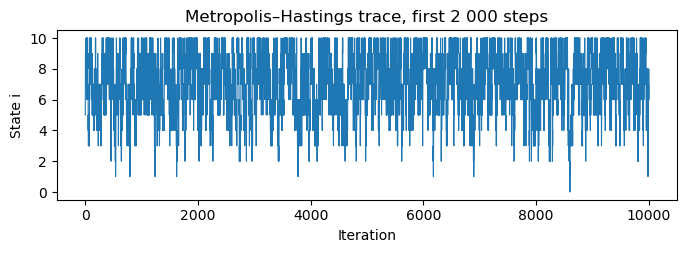

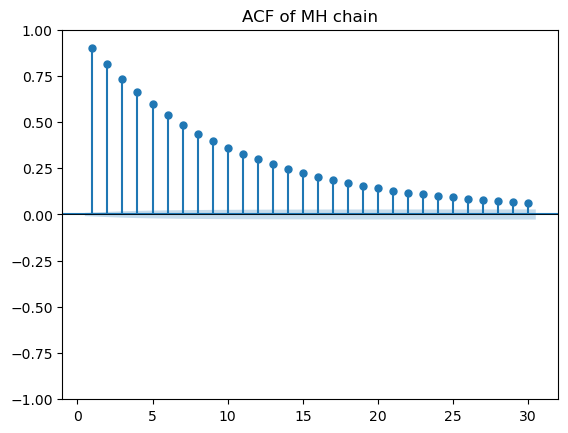

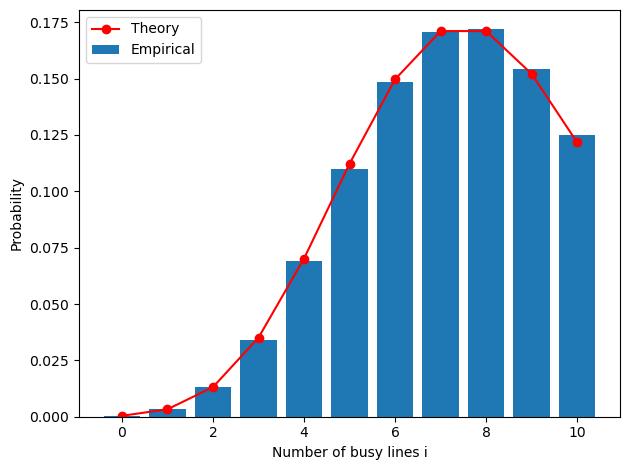

In [ ]:
plt.figure(figsize=(8,2.2))
plt.plot(sample[:10000], lw=0.8)      # first 2 000 iterations
plt.xlabel("Iteration")
plt.ylabel("State i")
plt.title("Metropolis–Hastings trace")
plt.show()

from statsmodels.graphics.tsaplots import plot_acf
plot_acf(sample, lags=30, zero=False)
plt.axhline(0, color='k', lw=0.6)
plt.title("ACF of MH chain")
plt.show()

k_vals = np.arange(m+1)
plt.bar(k_vals, counts/len(sample), width=0.8, label="Empirical")
plt.plot(k_vals, P, "o-", color="red", label="Theory")
plt.xlabel("Number of busy lines i")
plt.ylabel("Probability")
plt.legend(); plt.tight_layout()
plt.show()


In [66]:
len(counts)

21

2).

In [141]:
# Parameters
A1, A2, m = 4, 4, 10

# Unnormalized target
def target(i, j):
    if 0 <= i and 0 <= j and i + j <= m:
        return (A1**i) * (A2**j) / (factorial(i) * factorial(j))
    else:
        return 0.0

# Build domain { (i,j): 0 <= i, 0 <= j, i+j <= m }
domain = [(i, j) for i in range(m + 1) for j in range(m + 1 - i)]
N = len(domain)
print("Domain size:", N)

# (a) Direct Metropolis–Hastings: propose uniformly over the whole domain
def direct_mh(n_samples, burn_in=10000):
    samples = []
    state = domain[np.random.randint(N)]
    accepts = 0
    for t in range(n_samples + burn_in):
        cand = domain[np.random.randint(N)]
        alpha = min(1, target(*cand) / target(*state))
        if np.random.rand() < alpha:
            state = cand
            if t >= burn_in:
                accepts += 1
        if t >= burn_in:
            samples.append(state)
    print("Direct MH acceptance rate:", accepts / n_samples)
    return samples

# (b) Coordinate-wise Metropolis–Hastings:
#     update i | j, then j | i with uniform proposals within valid range
def coord_mh(n_samples, burn_in=10000):
    samples = []
    state = domain[np.random.randint(N)]
    accepts_i = accepts_j = 0
    for t in range(n_samples + burn_in):
        i, j = state
        # Update i
        i_prop = np.random.randint(0, m - j + 1)
        alpha_i = min(1, target(i_prop, j) / target(i, j))
        if np.random.rand() < alpha_i:
            i = i_prop
            if t >= burn_in:
                accepts_i += 1
        # Update j
        j_prop = np.random.randint(0, m - i + 1)
        alpha_j = min(1, target(i, j_prop) / target(i, j))
        if np.random.rand() < alpha_j:
            j = j_prop
            if t >= burn_in:
                accepts_j += 1
        state = (i, j)
        if t >= burn_in:
            samples.append(state)
    print("Coord MH acceptance rates: i =", accepts_i / n_samples,
          ", j =", accepts_j / n_samples)
    return samples

# Run samplers
n = 80000
samples_direct = direct_mh(n)
samples_coord = coord_mh(n)

# Estimate joint pmf from samples
def estimate_pmf(samples):
    cnt = Counter(samples)
    total = len(samples)
    return {k: v/total for k, v in cnt.items()}

est_direct = estimate_pmf(samples_direct)
est_coord  = estimate_pmf(samples_coord)

# Compute exact normalized pmf
Z = sum(target(i,j) for i,j in domain)
exact = {k: target(*k)/Z for k in domain}

# Show top 10 states by exact probability, and the sample estimates
print("\n Top 10 states (i,j) by exact P(i,j) vs. estimates:\n")
print(f"{'State':>8} | {'Exact':>8} | {'Direct MH':>10} | {'Coord MH':>10}")
print("-"*46)
for (i,j) in sorted(exact, key=exact.get, reverse=True)[:10]:
    print(f"{(i,j)!s:>8} | {exact[(i,j)]:8.4f} | "
          f"{est_direct.get((i,j),0):10.4f} | {est_coord.get((i,j),0):10.4f}")


cnt_direct = Counter(samples_direct)
cnt_coord = Counter(samples_coord)
#cnt_Gibbs = Counter(samples_Gibbs)

obs_direct = np.array([cnt_direct[(i,j)] for (i,j) in domain])
obs_coord = np.array([cnt_coord[(i,j)] for (i,j) in domain])
#obs_Goibbs = np.array([cnt_direct[(i,j)] for (i,j) in domain])

exp = n * np.array([ exact[(i,j)] for (i,j) in domain ])

chi2_stat_direct, p_value_direct = chisquare(f_obs=obs_direct, f_exp=exp)
chi2_stat_coord, p_value_coord = chisquare(f_obs=obs_coord, f_exp=exp)



print(f'Directstat:{chi2_stat_direct} pvaluedirect: {p_value_direct}')
print(f'coordtstat:{chi2_stat_coord} pvaluecoord: {p_value_coord}')




Domain size: 66
Direct MH acceptance rate: 0.4798625
Coord MH acceptance rates: i = 0.6944375 , j = 0.6929

 Top 10 states (i,j) by exact P(i,j) vs. estimates:

   State |    Exact |  Direct MH |   Coord MH
----------------------------------------------
  (3, 3) |   0.0468 |     0.0460 |     0.0476
  (3, 4) |   0.0468 |     0.0457 |     0.0468
  (4, 3) |   0.0468 |     0.0469 |     0.0484
  (4, 4) |   0.0468 |     0.0473 |     0.0456
  (3, 5) |   0.0374 |     0.0376 |     0.0370
  (4, 5) |   0.0374 |     0.0371 |     0.0390
  (5, 3) |   0.0374 |     0.0365 |     0.0377
  (5, 4) |   0.0374 |     0.0382 |     0.0368
  (2, 3) |   0.0351 |     0.0364 |     0.0344
  (2, 4) |   0.0351 |     0.0357 |     0.0357
Directstat:117.45876410724944 pvaluedirect: 7.330366682872451e-05
coordtstat:87.46824206695212 pvaluecoord: 0.0330623588698328


In [143]:

# Build domain
domain = [(i, j) for i in range(m + 1) for j in range(m + 1 - i)]
N_states = len(domain)

Z = sum(target(i, j) for i, j in domain)
exact_pmf = {s: target(*s) / Z for s in domain}

# (c) Gibbs sampler
def gibbs_sampling(n_samples, burn_in=1000):
    samples = []
    # initialize arbitrarily
    i, j = domain[np.random.randint(N_states)]
    for t in range(n_samples + burn_in):
        # sample i | j
        weights_i = [A1**i0 / factorial(i0) 
                     for i0 in range(m - j + 1)]
        probs_i = np.array(weights_i) / sum(weights_i)
        i = np.random.choice(range(m - j + 1), p=probs_i)
        # sample j | i
        weights_j = [A2**j0 / factorial(j0) 
                     for j0 in range(m - i + 1)]
        probs_j = np.array(weights_j) / sum(weights_j)
        j = np.random.choice(range(m - i + 1), p=probs_j)
        if t >= burn_in:
            samples.append((i, j))
    return samples

# Run Gibbs
n = 10000
samples_gibbs = gibbs_sampling(n)

# Empirical counts
counts = Counter(samples_gibbs)
obs = np.array([counts.get(s, 0) for s in domain])
exp = np.array([n * exact_pmf[s] for s in domain])

# Chi-squared goodness-of-fit
chi2_stat, p_value = chisquare(f_obs=obs, f_exp=exp)

# Print results
print(f"Ran Gibbs sampler with {n} post–burn-in draws.")
print(f"Chi-squared statistic: {chi2_stat:.2f}, p-value: {p_value:.3f}")

# Compare top-10 states
print("\nState | Exact   | Gibbs Est.")
print("-----------------------------")
empirical_pmf = {s: counts[s]/n for s in domain}
for s in sorted(exact_pmf, key=exact_pmf.get, reverse=True)[:10]:
    print(f"{s!s:7} | {exact_pmf[s]:7.4f} | {empirical_pmf.get(s,0):8.4f}")

Ran Gibbs sampler with 10000 post–burn-in draws.
Chi-squared statistic: 38.87, p-value: 0.996

State | Exact   | Gibbs Est.
-----------------------------
(3, 3)  |  0.0468 |   0.0493
(3, 4)  |  0.0468 |   0.0452
(4, 3)  |  0.0468 |   0.0473
(4, 4)  |  0.0468 |   0.0474
(3, 5)  |  0.0374 |   0.0387
(4, 5)  |  0.0374 |   0.0393
(5, 3)  |  0.0374 |   0.0378
(5, 4)  |  0.0374 |   0.0355
(2, 3)  |  0.0351 |   0.0357
(2, 4)  |  0.0351 |   0.0360


3).

Prior draw  Θ = 2.831,  Ψ = 1.960
Simulated data: [4.634 3.102 4.119 3.638 1.94  3.589 2.387 2.379 2.967 0.695]


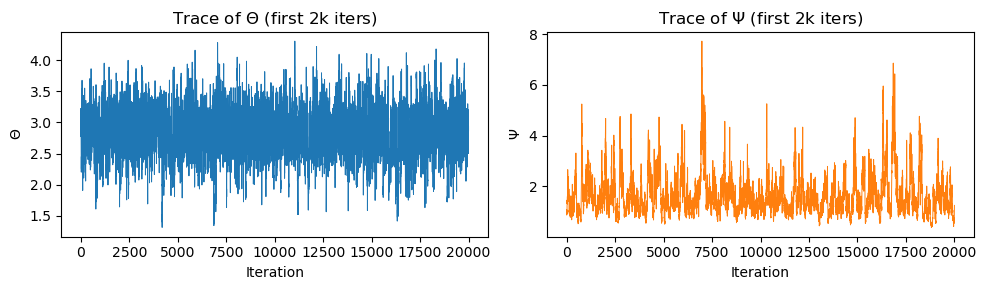

Posterior mean(Θ) = 2.823
Posterior mean(Ψ) = 1.624


In [ ]:


# ------------------------------------------------------------------
# 3. Posterior sampling via random-walk MH in (ξ, γ) space
def log_prior(xi, gamma):
    return multivariate_normal(mean=[0, 0], cov=Σ).logpdf([xi, gamma])

def log_lik(xi, gamma):
    θ = np.exp(xi)
    ψ = np.exp(gamma)
    return norm(loc=θ, scale=np.sqrt(ψ)).logpdf(data).sum()

def log_post(xi, gamma):
    return log_prior(xi, gamma) + log_lik(xi, gamma)

# --- M-H settings
n_iter    = 60_000
burn      = 10_000
sigma_prop= 0.10                 # proposal std-dev (tune!)

chain = np.empty((n_iter, 2))
xi_cur, gamma_cur = 0.0, 0.0     # initial guess (log-space)

logp_cur = log_post(xi_cur, gamma_cur)

for t in range(n_iter):
    xi_prop, gamma_prop = rng.normal([xi_cur, gamma_cur],
                                     sigma_prop, size=2)
    logp_prop = log_post(xi_prop, gamma_prop)
    
    if np.log(rng.random()) < (logp_prop - logp_cur):
        xi_cur, gamma_cur, logp_cur = xi_prop, gamma_prop, logp_prop

    chain[t] = (xi_cur, gamma_cur)

post = chain[burn:]              # discard burn-in
theta_post = np.exp(post[:,0])
psi_post   = np.exp(post[:,1])

# ------------------------------------------------------------------
# 4. Quick diagnostics
fig, ax = plt.subplots(1, 2, figsize=(10,3))
ax[0].plot(theta_post[:20000], lw=0.7)
ax[0].set_title(r"Trace of $\Theta$ (first 2k iters)")
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel(r"$\Theta$")

ax[1].plot(psi_post[:20000], lw=0.7, color="tab:orange")
ax[1].set_title(r"Trace of $\Psi$ (first 2k iters)")
ax[1].set_xlabel("Iteration")
ax[1].set_ylabel(r"$\Psi$")

plt.tight_layout(); plt.show()

# Pair-plot of posterior draws (optional eye-candy)


print(f"Posterior mean(Θ) = {theta_post.mean():.3f}")
print(f"Posterior mean(Ψ) = {psi_post.mean():.3f}")


Prior draw  Θ = 2.831,  Ψ = 1.960
Simulated data: [ 4.634  3.102  4.119  3.638  1.94   3.589  2.387  2.379  2.967  0.695
  4.499  1.891  4.231  3.021  4.975  1.907  2.394  3.303 -0.259  3.99
  4.989  4.408  3.887  2.626  4.625  4.334  3.38   2.838  2.324  1.109
  4.547 -0.21   2.312  3.061  4.034  5.297  4.221  2.423  3.85   1.065
  4.832  2.612  1.887  1.936  2.745  2.281  6.036  1.825  2.876  2.87
  2.87   2.908  2.157  2.014  1.624  0.747  3.133  4.209  2.07   2.049
  2.388  2.186  0.82   4.742  3.445  1.834  3.247  2.217  2.534  3.34
  4.165  4.958  5.216  2.482  2.131  2.97   3.01   1.803  1.962  3.969
  5.129  2.514  1.924  2.434  1.438  2.449  3.422  2.717  4.559  3.042
  3.504  2.622  4.672  1.12   2.406  1.188  3.987  4.021  2.109  5.152
  2.415  0.894  2.437  3.335  2.503  6.002  4.028  5.254  4.771  0.471
  2.302 -0.989  1.926  4.392  1.65   1.939  3.287  3.933  2.332  2.473
  3.963  3.186  2.431  3.271  2.937  3.187  5.632  2.403  2.075  4.809
  1.843  5.238  2.559  2.934  

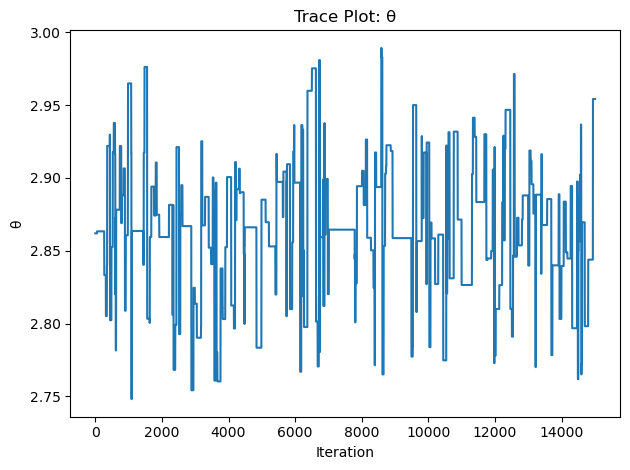

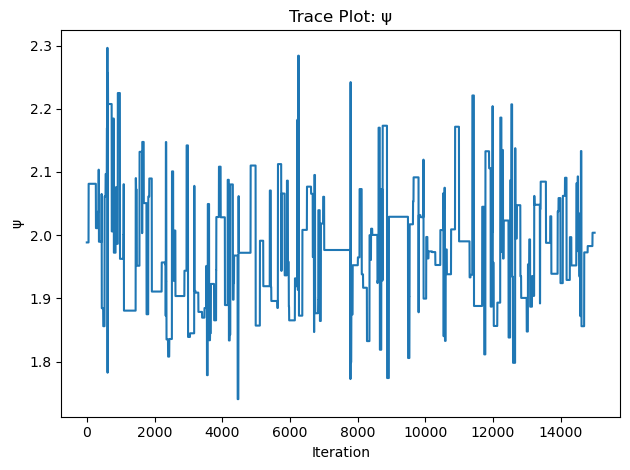

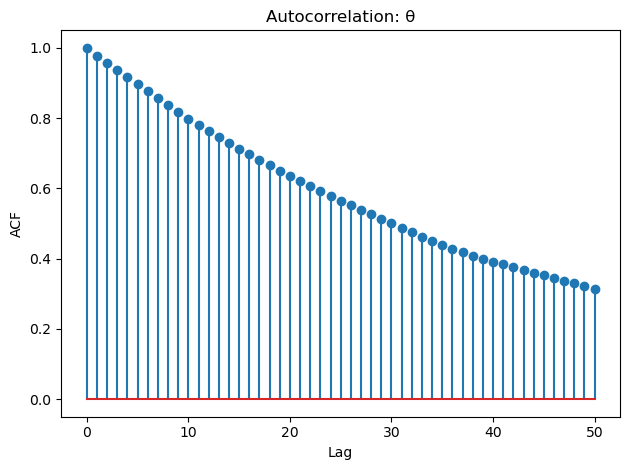

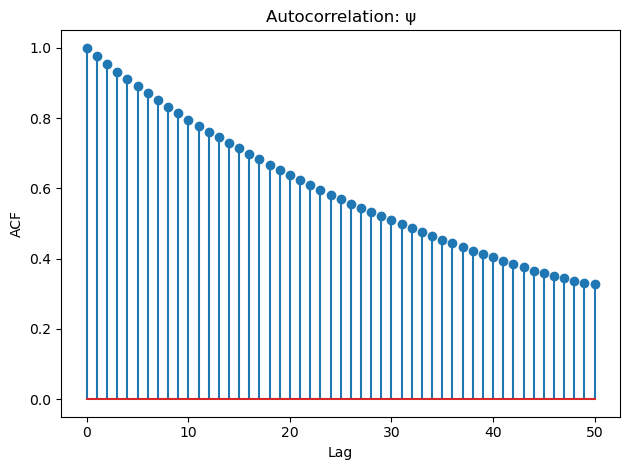

In [145]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import multivariate_normal, norm

# ------------------------------------------------------------------
# 1. Prior:  (Ξ, Γ) = (log Θ, log Ψ) ~ N(0, Σ) with corr ρ = 0.5
rho = 0.5
cov = np.array([[1.0, rho],
              [rho, 1.0]])
rng = np.random.default_rng(123)

xi,  gamma = rng.multivariate_normal(mean=[0, 0], cov=cov)
theta = np.exp(xi)           # Θ  (mean parameter)
psi   = np.exp(gamma)        # Ψ  (variance parameter)

print(f"Prior draw  Θ = {theta:.3f},  Ψ = {psi:.3f}")

# ------------------------------------------------------------------
# 2. Simulated data  X_i ~ N(Θ, Ψ)
n   = 1000
X = rng.normal(loc=theta, scale=np.sqrt(psi), size=n)
print("Simulated data:", np.round(X, 3))

# ——— Precompute data summaries ———
xbar = np.mean(X)
s2   = np.var(X, ddof=1)
rho  = 0.5

def logpost(xi, gamma):
    # transform back
    theta = np.exp(xi)
    psi   = np.exp(gamma)
    # log‐prior bivariate normal on (ξ,γ)
    Q = ( xi**2 - 2*rho*xi*gamma + gamma**2 )/(2*(1-rho**2))
    # log‐likelihood in transformed form
    LL = - (n/2)*gamma \
         - ( n*(xbar-theta)**2 + (n-1)*s2 )/(2*psi)
    return -Q + LL

# ——— Tuning parameters ———
Σ_prop = np.diag([0.1, 0.1])  # try σ_ξ=σ_γ=0.1 to start
n_iter  = 20000
burn_in = 5000

# ——— Storage ———
chain = np.zeros((n_iter, 2))
accept = 0

# ——— Initialize at the log‐prior mean ———
xi, gamma = 0.0, 0.0

for t in range(n_iter):
    # 1) propose
    xi_p, gamma_p = np.random.multivariate_normal([xi, gamma], Σ_prop)
    # 2) accept/reject
    logα = logpost(xi_p, gamma_p) - logpost(xi, gamma)
    if np.log(np.random.rand()) < logα:
        xi, gamma = xi_p, gamma_p
        accept += 1
    # 3) record
    chain[t] = [xi, gamma]

print("Acceptance rate:", accept/n_iter)

# ——— Discard burn‐in and transform back ———
post = chain[burn_in:]
theta_samps = np.exp(post[:,0])
psi_samps   = np.exp(post[:,1])

theta_ci = np.percentile(theta_samps, [2.5, 97.5])
psi_ci = np.percentile(psi_samps, [2.5, 97.5])

print(f"95% CI for θ: [{theta_ci[0]:.3f}, {theta_ci[1]:.3f}]")
print(f"95% CI for ψ: [{psi_ci[0]:.3f}, {psi_ci[1]:.3f}]")

def autocorr(x, max_lag=50):
    acf = [1.0]
    x = x - np.mean(x)
    var = np.var(x)
    n = len(x)
    for lag in range(1, max_lag+1):
        acf.append(np.sum(x[:-lag]*x[lag:])/(n-lag)/var)
    return acf

lags = np.arange(51)
ac_theta = autocorr(theta_samps)
ac_psi = autocorr(psi_samps)

# Trace for θ
plt.figure()
plt.plot(theta_samps)
plt.title("Trace Plot: θ")
plt.xlabel("Iteration")
plt.ylabel("θ")
plt.tight_layout()

# Trace for ψ
plt.figure()
plt.plot(psi_samps)
plt.title("Trace Plot: ψ")
plt.xlabel("Iteration")
plt.ylabel("ψ")
plt.tight_layout()

# Autocorr for θ
plt.figure()
plt.stem(lags, ac_theta)
plt.title("Autocorrelation: θ")
plt.xlabel("Lag")
plt.ylabel("ACF")
plt.tight_layout()

# Autocorr for ψ
plt.figure()
plt.stem(lags, ac_psi)
plt.title("Autocorrelation: ψ")
plt.xlabel("Lag")
plt.ylabel("ACF")
plt.tight_layout()

plt.show()

In [124]:
np.mean(theta_samps), np.mean(psi_samps)

(2.8260427146175315, 1.6781488765691512)